<a href="https://colab.research.google.com/github/ShotaSasaki-HU/text-readability-assessor/blob/main/readability_of_the_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing（環境の準備）

## Importing Libraries

In [156]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import numpy as np

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Reading "group_work_text.csv"
この文章に対するスコアを予測したい．

In [130]:
path_csv = "https://github.com/ShotaSasaki-HU/text-difficulty-assessor/raw/refs/heads/main/group_work_text.csv"
df_group_work_text = pd.read_csv(path_csv, encoding="utf-8", header=0)
df_group_work_text


,docid,text
0,doc01,There are four seasons in a year. They are spr...
1,doc02,The public library is a very quiet place. It i...
2,doc03,Many people want to build better habits. They ...
3,doc04,Many people enjoy growing a garden in their ya...
4,doc05,Many people want to use their time better. The...
5,doc06,Waiting is part of daily life. People wait for...
6,doc07,Getting enough sleep is essential for maintain...
7,doc08,Rules are created to provide order and reduce ...
8,doc09,Electricity is a power that has changed human ...
9,doc10,Electric cars are becoming very popular around...


## Reading "cefr_leveled_texts.csv"（教師データ）
このデータから切り出した訓練データと検証データを使って，良いモデルを作る．

In [131]:
path_csv = "https://github.com/ShotaSasaki-HU/text-difficulty-assessor/raw/refs/heads/main/cefr_leveled_texts.csv"
df = pd.read_csv(path_csv, encoding="utf-8", header=0)
df


,text,label
0,Hi!\nI've been meaning to write for ages and f...,B2
1,﻿It was not so much how hard people found the ...,B2
2,Keith recently came back from a trip to Chicag...,B2
3,"The Griffith Observatory is a planetarium, and...",B2
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2
...,...,...
1489,Light propagating in the vicinity of astrophys...,C2
1490,Future of dentistry has become one of the most...,C2
1491,﻿The forests – and suburbs – of Europe are ech...,C2
1492,Hedge funds are turning bullish on oil once ag...,C2


In [132]:
# ユニークなラベルの確認
df['label'].unique()


array(['B2', 'A2', 'C1', 'B1', 'A1', 'C2'], dtype=object)

# Response Variable（目的変数）

In [133]:
# Convert CEFR to numerical values
mapping = {"A1": 1, "A2": 2, "B1": 3, "B2": 4, "C1": 5, "C2": 6}
df['label'] = df['label'].map(mapping)
df


,text,label
0,Hi!\nI've been meaning to write for ages and f...,4
1,﻿It was not so much how hard people found the ...,4
2,Keith recently came back from a trip to Chicag...,4
3,"The Griffith Observatory is a planetarium, and...",4
4,-LRB- The Hollywood Reporter -RRB- It's offici...,4
...,...,...
1489,Light propagating in the vicinity of astrophys...,6
1490,Future of dentistry has become one of the most...,6
1491,﻿The forests – and suburbs – of Europe are ech...,6
1492,Hedge funds are turning bullish on oil once ag...,6


# Explanatory Variable（説明変数）

## １. Average Sentence Length in a Single Document（単一ドキュメントにおける文長の平均）
文長の定義：一つの文における，カンマやピリオドを除いた単語数の事とする．

### Create the Column（列の作成）

In [134]:
def calc_mean_sentence_length(text):
    sentences = sent_tokenize(text) # 文の分割
    sentences = [s.strip() for s in sentences if s.strip()] # 前後端の空白を削除

    list_of_tokens = [] # リストのリスト
    for sent in sentences:
        tokens = word_tokenize(sent) # <class 'list'>

        # isalnum()は，英数字のみで構成されているか判定する．
        # カンマやピリオドを取り除くことができる．
        # ただし 's や n't や set-up は，anyをいれる事で消さないようにしている．
        tokens = [token for token in tokens if any(c.isalnum() for c in token)]

        list_of_tokens.append(tokens)

    lengths = [len(tokens) for tokens in list_of_tokens]

    return sum(lengths) / len(lengths)

df['mean_sentence_length'] = df['text'].apply(calc_mean_sentence_length)
df.head(5)


,text,label,mean_sentence_length
0,Hi!\nI've been meaning to write for ages and f...,4,18.192308
1,﻿It was not so much how hard people found the ...,4,19.764706
2,Keith recently came back from a trip to Chicag...,4,17.071429
3,"The Griffith Observatory is a planetarium, and...",4,19.000000
4,-LRB- The Hollywood Reporter -RRB- It's offici...,4,19.722222


### Scatter Plot（散布図）

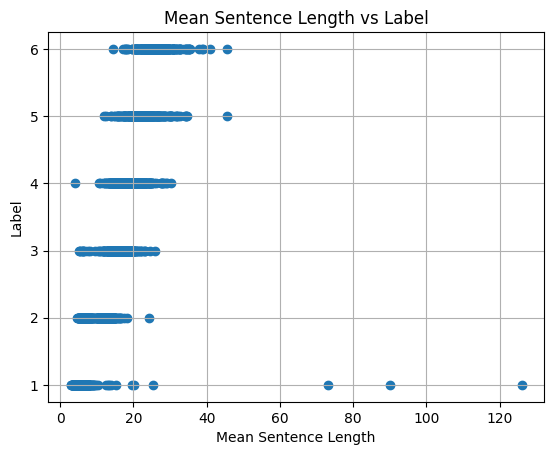

In [135]:
plt.figure()
plt.scatter(df['mean_sentence_length'], df['label'])
plt.xlabel('Mean Sentence Length')
plt.ylabel('Label')
plt.title('Mean Sentence Length vs Label')
plt.grid()
plt.show()


### Outlier Removal（外れ値の除去）

In [136]:
df[(df['label'] == 1) & (df['mean_sentence_length'] > 60)]


,text,label,mean_sentence_length
1068,"\nTony's Kitchen\n231 reviews\nChicken, Pizzas...",1,126.0
1113,DEPARTURES\nTime\tFlight\tDestination\tGate\tR...,1,73.0
1223,KPD Foods\nBruno Silva\nHead of Marketing\nAdd...,1,90.0


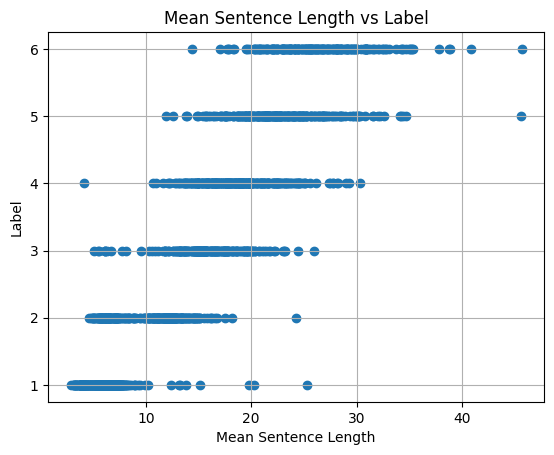

In [137]:
df = df.drop(index=[1068, 1113, 1223])

plt.figure()
plt.scatter(df['mean_sentence_length'], df['label'])
plt.xlabel('Mean Sentence Length')
plt.ylabel('Label')
plt.title('Mean Sentence Length vs Label')
plt.grid()
plt.show()


## ２. Measuring Sentence Readability by Word Difficulty

### 10.000 ENGLISH WORDS CERF LABELLED from Kaggleを単語の難易度ラベルとして使用
- CEFR A1 as pre school level
- CEFR A2 as elementary school level
- CEFR B1 as secondary school level
- CEFR B2 as high school school level
- CEFR C1 and C2 as academic level


In [167]:
url = "https://github.com/ShotaSasaki-HU/text-readability-assessor/raw/refs/heads/main/ENGLISH_CERF_WORDS.csv"
df_word_to_cefr = pd.read_csv(url, encoding="utf-8", header=0)

# 1. スラッシュでくっついている単語を分割して行を増やす．
df_word_to_cefr['headword'] = df_word_to_cefr['headword'].astype(str).str.split('/')
df_word_to_cefr = df_word_to_cefr.explode('headword')

# 2. 小文字化
df_word_to_cefr['headword'] = df_word_to_cefr['headword'].str.lower().str.strip()

# 3. ステミング
# 辞書側も 'library' -> 'librari' のようにステミングしておくことで，
# 入力テキストの 'librari' とマッチするようにする．
# df_word_to_cefr.loc[len(df_word_to_cefr)] = {'headword': 'library', 'CEFR': 'fake'} # 確認用
stemmer = PorterStemmer()
df_word_to_cefr['stemmed_word'] = df_word_to_cefr['headword'].apply(stemmer.stem)

# 4. 検索用マップ（辞書）の作成
# 重複がある場合（同じ語幹で違うレベルなど）もあるが今回は簡単化のために無視する．
cefr_map = dict(zip(df_word_to_cefr['stemmed_word'], df_word_to_cefr['CEFR']))

print(list(cefr_map.items())[:10]) # 確認用


[('a', 'A1'), ('a.m.', 'A1'), ('am', 'A1'), ('abandon', 'B2'), ('abil', 'A2'), ('abl', 'B1'), ('abnorm', 'B2'), ('aboard', 'C1'), ('abolish', 'C2'), ('aborigin', 'B1')]


# Linear Multiple Regression Model（線形重回帰モデル）

## Training（訓練）

In [138]:
X = df[["mean_sentence_length"]].values # 説明変数
y = df["label"].values # 目的変数

# 学習/検証分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

## Validation（検証）
Evaluate the model using the validation data split from the training data (cefr_leveled_texts.csv) with train_test_split. We will refine the explanatory variables to improve the evaluation of this section.

教師データからtrain_test_splitで分割した検証データによって，モデルを評価する．このセクションの評価が良くなるように説明変数を工夫する．


### ★１. Model Performance Metrics（モデルの性能を示す指標）
- Coefficient (model.coef_): Shows the effect of each feature on the target variable. Features with very small absolute values may be meaningless. （各特徴量が目的変数に与える影響を表す．絶対値が小さすぎると意味のない説明変数である可能性がある．）
- Intercept (model.intercept_): The predicted value when all features are zero. Its magnitude does not indicate model quality. （すべての特徴量が0のときの予測値．大きい/小さいはモデル精度とは関係ない．）
- MSE (Mean Squared Error): Measures the average squared difference between predicted and actual values. Smaller is better. （予測値と実測値の二乗誤差の平均を表す指標．小さいほど良い．）
- R² (Coefficient of Determination): Indicates how well the model explains the variance of the data. Closer to 1 is better. （モデルがデータのばらつきをどれだけ説明できるかを示す指標．1に近いほど良い．）

In [139]:
y_pred = model.predict(X_test)

print("係数:", model.coef_)
print("切片:", model.intercept_)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


係数: [0.18858776]
切片: 0.30123633354533164
MSE: 0.6511852488765654
R^2: 0.7718838411525833


### ★２. Residual Plot（残差プロット）
A residual plot visualizes the differences between predicted and actual values (residuals). It helps to intuitively check whether the assumptions of a linear regression model—linearity, homoscedasticity, and the presence of outliers—are satisfied.

残差プロットは，予測値と実際の値の差（残差）を可視化するグラフです．これにより，線形回帰モデルの前提条件（線形性・残差の均一性・異常値の有無）が守られているかを直感的に確認できます．
***
What to check in a residual plot / 残差プロットで具体的に確認すべきこと
- Random distribution / ランダムな分布か
    - 点がランダムに散らばっていれば，線形性や等分散性の前提が概ね満たされている．
- Patterns or trends / パターンや傾向がないか
    - 曲線や傾きがある場合，線形モデルが適していない可能性あり．
- Homoscedasticity / 残差の均一性
    - 縦の広がりが一定か（先細りや先太りになっていないか）．
- Outliers / 外れ値の有無
    - 残差が極端に大きい点はないほうが良い．
    
https://www.qualtrics.com/support/jp/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

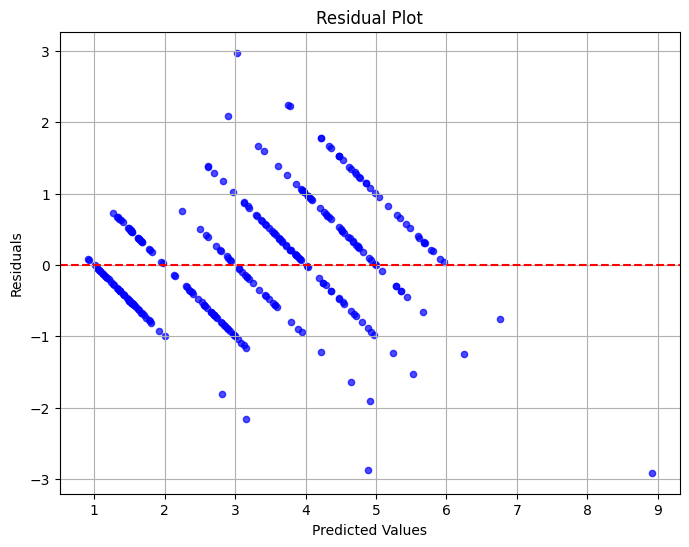

In [140]:
# 残差を計算
residuals = y_test - y_pred

# 残差プロット（予測値 vs 残差）
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, s=20, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--') # 残差0の基準線
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


### ３. Scatter Plot (True Values vs Predicted Values)
This code visualizes the model’s predictions (y_pred) against the true values (y_test) in a scatter plot. The red dashed line y = x represents the ideal scenario where all predictions perfectly match the true values, serving as a reference to intuitively assess prediction accuracy.

ここでは，モデルの予測値 (y_pred) と実際の値 (y_test) を散布図で比較します．赤い破線 y = x は完全に一致する理想の予測を表す基準として，予測の精度を直感的に確認するための線です．

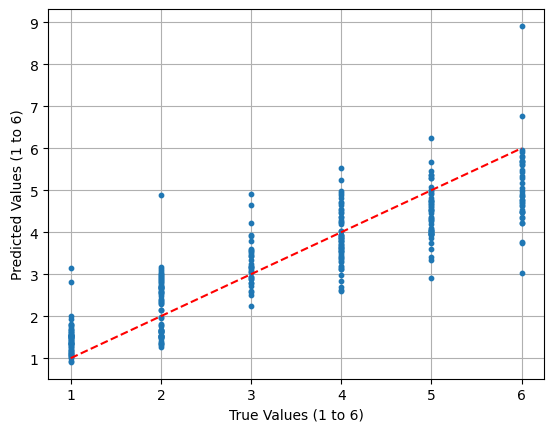

In [141]:
plt.scatter(y_test, y_pred, s=10, zorder=2)
plt.xlabel("True Values (1 to 6)")
plt.ylabel("Predicted Values (1 to 6)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', zorder=3)

plt.grid(True, zorder=0)
plt.show()

### ４. Correlation Heatmap of Explanatory Variables（説明変数間の相関）

A correlation heatmap of explanatory variables is a plot that shows the strength of linear relationships between all explanatory variables using colors. Linear regression models assume that explanatory variables are not highly correlated (no multicollinearity), so variables may be removed to reduce multicollinearity.

説明変数間の相関ヒートマップは，各説明変数同士の線形関係の強さを色で示すグラフです．線形回帰モデルは，説明変数間に強い相関（多重共線性）がない事を前提としているため，多重共線性を無くせるように説明変数を削ります．

https://plaza.umin.ac.jp/~health-stat/faq/faq21/

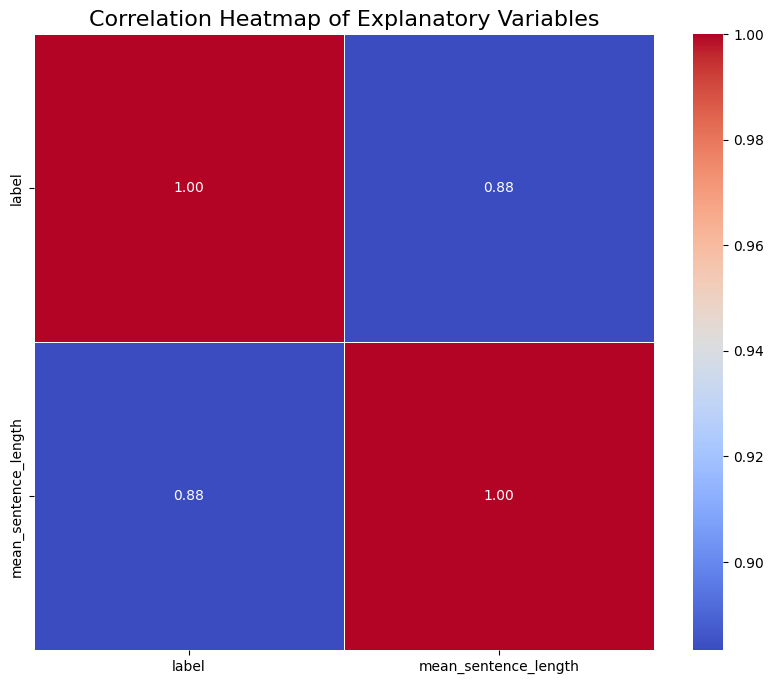

In [146]:
# 数値列だけを抽出
numeric_df = df.select_dtypes(include='number')#.drop(columns=['label'])

# ヒートマップのサイズを指定
plt.figure(figsize=(10, 8))

# seabornのheatmap関数を呼び出す
sns.heatmap(
    numeric_df.corr(),         # データとして相関行列を渡す
    annot=True,        # セル内に数値を表示する
    cmap='coolwarm',   # 色のマップを指定（正の相関は暖色、負の相関は寒色）
    fmt='.2f',         # 数値の書式（小数点以下2桁）
    linewidths=.5      # セル間の線の太さ
)

plt.title('Correlation Heatmap of Explanatory Variables', fontsize=16)
plt.show()


# ★Automatic Readability Assessment
これがそもそもの目的でした．

In [143]:
# 使用する特徴量計算関数オブジェクトをリストにまとめる
feature_functions = [
    calc_mean_sentence_length,
    # 新しい特徴量を作ったらここに追加
]

# ループで一括適用
# 関数名 = 'calc_' + カラム名，となるように工夫しておくと管理が楽．
for func in feature_functions:
    # func.__name__ で関数名（例: 'calc_mean_sentence_length'）が取れるので，
    # 'calc_'を取り払ってカラム名にする．
    col_name = func.__name__.replace('calc_', '')

    # 予測対象データに適用
    df_group_work_text[col_name] = df_group_work_text['text'].apply(func)

print(df_group_work_text.head())
print('------------------------------')

# 予測実行
feature_cols = [f.__name__.replace('calc_', '') for f in feature_functions] # カラム名リストを自動生成
X = df_group_work_text[feature_cols].values
y_pred = model.predict(X)
print(y_pred)


   docid                                               text  \
0  doc01  There are four seasons in a year. They are spr...   
1  doc02  The public library is a very quiet place. It i...   
2  doc03  Many people want to build better habits. They ...   
3  doc04  Many people enjoy growing a garden in their ya...   
4  doc05  Many people want to use their time better. The...   

   mean_sentence_length  
0             10.037037  
1              8.057143  
2              8.487179  
3             10.888889  
4             11.137931  
------------------------------
[2.19409865 1.82071484 1.90181449 2.35474748 2.40171378 1.69954557
 2.99534717 2.89431801 2.16996957 3.77439422]


In [144]:
# np.round: 最も近い整数に丸める
# np.clip: 予測値が 0.8 なら 1 に，6.5 なら 6 に補正する（範囲外対策）．
y_pred_int = np.clip(np.round(y_pred), 1, 6).astype(int)

# mapping = {"A1": 1, ..., "C2": 6} のキーと値を反転
inverse_mapping = {v: k for k, v in mapping.items()}
# 整数をCEFRラベルに変換
pred_cefr_labels = [inverse_mapping[val] for val in y_pred_int]

df_group_work_text['pred_score'] = y_pred
df_group_work_text['pred_level'] = pred_cefr_labels

cols_to_show = ['docid', 'text', 'pred_score', 'pred_level']
df_group_work_text[cols_to_show]


,docid,text,pred_score,pred_level
0,doc01,There are four seasons in a year. They are spr...,2.194099,A2
1,doc02,The public library is a very quiet place. It i...,1.820715,A2
2,doc03,Many people want to build better habits. They ...,1.901814,A2
3,doc04,Many people enjoy growing a garden in their ya...,2.354747,A2
4,doc05,Many people want to use their time better. The...,2.401714,A2
5,doc06,Waiting is part of daily life. People wait for...,1.699546,A2
6,doc07,Getting enough sleep is essential for maintain...,2.995347,B1
7,doc08,Rules are created to provide order and reduce ...,2.894318,B1
8,doc09,Electricity is a power that has changed human ...,2.169970,A2
9,doc10,Electric cars are becoming very popular around...,3.774394,B2
